# Informações

Nome: Francisco Altanizio Batista de Castro Junior

Matrícula: 575220

Curso: ENGENHARIA DE TRANSPORTES

Disciplina: CKP8277 - APRENDIZAGEM AUTOMÁTICA

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, rv_discrete

In [161]:
random_1 = np.random.default_rng(seed=1)

In [162]:
random_1.normal(size=(5,5))

array([[ 0.34558419,  0.82161814,  0.33043708, -1.30315723,  0.90535587],
       [ 0.44637457, -0.53695324,  0.5811181 ,  0.3645724 ,  0.2941325 ],
       [ 0.02842224,  0.54671299, -0.73645409, -0.16290995, -0.48211931],
       [ 0.59884621,  0.03972211, -0.29245675, -0.78190846, -0.25719224],
       [ 0.00814218, -0.27560291,  1.29406381,  1.00672432, -2.71116248]])

In [163]:
class MLP:
    """ """

    def __init__(
        self,
        X,
        y,
        X_teste,
        y_teste,
        mode="Regression",
        hidden_size=100,
        learning_rate=0.1,
        momentum=0,
        epochs=1000,
        batch_size=16,
        lambda_l2=0,
        scheduler_learning_rate=None,
        eval=True,
        seed=2,
    ):
        self.historico_custo = []
        self.X = X
        self.y = y
        self.X_teste = X_teste
        self.y_teste = y_teste
        self.mode = mode
        self.epochs = epochs
        self.batch_size = batch_size
        self.lambda_l2 = lambda_l2
        self.scheduler_learning_rate = scheduler_learning_rate
        self.eval = eval

        input_size = self.X.shape[1]

        self.random_1 = np.random.default_rng(seed)
        self.random_2 = np.random.default_rng(seed + 1)
        if mode == "Regression":
            output_size = 1
            self.W1 = self.random_1.normal(size=(input_size, hidden_size)) * np.sqrt(
                1 / input_size
            )
            self.b1 = np.zeros((1, hidden_size))
            self.W2 = self.random_2.normal(size=(hidden_size, output_size)) * np.sqrt(
                1 / hidden_size
            )
            self.b2 = np.zeros((1, output_size))
        else:
            output_size = len(np.unique(self.y))
            self.W1 = self.random_1.normal(size=(input_size, hidden_size)) * np.sqrt(
                2 / input_size
            )
            self.b1 = np.zeros((1, hidden_size)) + 0.01
            self.W2 = self.random_2.normal(size=(hidden_size, output_size)) * np.sqrt(
                2 / hidden_size
            )
            self.b2 = np.zeros((1, output_size)) + 0.01

        self.base_learning_rate = learning_rate
        self.momentum = momentum

        self.v_W1 = np.zeros_like(self.W1)
        self.v_b1 = np.zeros_like(self.b1)
        self.v_W2 = np.zeros_like(self.W2)
        self.v_b2 = np.zeros_like(self.b2)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        cross_entropy_loss = -np.log(y_pred[range(m), y_true] + 1e-8).mean()
        return cross_entropy_loss

    def mse(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2) / 2

    def activation_function(self, Z):
        if self.mode == "Regression":
            return self.tanh(Z)
        elif self.mode == "Classification":
            return self.relu(Z)

    def activation_function_derivate(self, Z):
        if self.mode == "Regression":
            return self.tanh_derivative(Z)
        elif self.mode == "Classification":
            return self.relu_derivative(Z)

    def output_function(self, Z):
        if self.mode == "Regression":
            return Z
        elif self.mode == "Classification":
            return self.softmax(Z)

    def cost_function(self, y_pred, y_true):
        if self.mode == "Regression":
            return self.mse(y_pred, y_true)
        elif self.mode == "Classification":
            return self.cross_entropy_loss(y_pred, y_true)

    def forward(self, X):
        self.U = X @ self.W1 + self.b1
        self.Z = self.activation_function(self.U)
        self.R = self.Z @ self.W2 + self.b2
        return self.output_function(self.R)

    def backward(self, X, y, y_pred):
        m = X.shape[0]

        if self.mode == "Regression":
            delta = (y_pred - y) / m
        elif self.mode == "Classification":
            delta = y_pred.copy()
            delta[range(m), y] -= 1
            delta /= m

        teta = (delta @ self.W2.T) * self.activation_function_derivate(self.U)

        dW2 = self.Z.T @ delta
        dW1 = X.T @ teta
        db2 = np.sum(delta, axis=0, keepdims=True)
        db1 = np.sum(teta, axis=0, keepdims=True)

        dW2 += self.lambda_l2 * self.W2 / m
        dW1 += self.lambda_l2 * self.W1 / m

        return dW1, db1, dW2, db2

    def update_weights(self, dW1, db1, dW2, db2):
        self.v_W2 = self.momentum * self.v_W2 - self.learning_rate * dW2
        self.v_b2 = self.momentum * self.v_b2 - self.learning_rate * db2
        self.v_W1 = self.momentum * self.v_W1 - self.learning_rate * dW1
        self.v_b1 = self.momentum * self.v_b1 - self.learning_rate * db1

        self.W2 += self.v_W2
        self.b2 += self.v_b2
        self.W1 += self.v_W1
        self.b1 += self.v_b1

    def update_learning_rate(self, epoch):
        if self.scheduler_learning_rate == "exponencial":
            self.learning_rate = self.base_learning_rate / (1 + epoch)
        elif self.scheduler_learning_rate == "linear":
            self.learning_rate = self.base_learning_rate * (1 - epoch / self.epochs)
        else:
            self.learning_rate = self.base_learning_rate

    def train(self):
        self.historico_custo = []
        n = self.X.shape[0]
        melhor_loss_test = float("inf")
        paciencia = 0
        tolerancia = 30
        delta_tolerancia = 1e-6

        for epoch in range(1, self.epochs + 1):
            # Embaralha os dados
            permutation = self.random_1.permutation(n)
            X_shuffled = self.X[permutation]
            y_shuffled = self.y[permutation]

            # Mini-batch gradient descent
            for i in range(0, n, self.batch_size):
                X_batch = X_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]

                y_pred = self.forward(X_batch)
                dW1, db1, dW2, db2 = self.backward(X_batch, y_batch, y_pred)

                self.update_learning_rate(epoch)
                self.update_weights(dW1, db1, dW2, db2)

            # Avaliação completa após a época
            y_pred_train = self.forward(self.X)
            y_pred_test = self.forward(self.X_teste)

            loss_train = self.cost_function(y_pred_train, self.y)
            loss_test = self.cost_function(y_pred_test, self.y_teste)

            self.historico_custo.append((epoch, loss_train, loss_test))

            if self.eval:
                print(
                    f"Epoch {epoch}/{self.epochs} - Loss: {loss_train:.4f} | Val Loss: {loss_test:.4f}"
                )

            # Early stopping
            if melhor_loss_test - loss_test >= delta_tolerancia:
                melhor_loss_test = loss_test
                paciencia = 0
            else:
                paciencia += 1
                if paciencia >= tolerancia:
                    if self.eval:
                        print(
                            f"Parando antecipadamente: sem melhora em {tolerancia} épocas consecutivas."
                        )
                    break

    def predict(self, X):
        y_pred = self.forward(X)
        if self.mode == "Regression":
            return y_pred
        elif self.mode == "Classification":
            return np.argmax(y_pred, axis=1)

In [164]:
class StandardScaler:
    """
    Classe para padronizar usando z-score
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, ddof=1, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.std

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse(self, X):
        return X * self.std + self.mean

In [165]:
class MinMax:
    """
    Classe para normalização Min-Max com intervalo customizável (ex: [-1, 1])
    """

    def __init__(self, feature_range=(-1, 1)):
        self.min_val = None
        self.max_val = None
        self.range_min, self.range_max = feature_range

    def fit(self, X):
        self.min_val = np.min(X, axis=0)
        self.max_val = np.max(X, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def transform(self, X):
        scale = (self.range_max - self.range_min) / (self.max_val - self.min_val)
        return self.range_min + (X - self.min_val) * scale

    def inverse(self, X):
        scale = (self.max_val - self.min_val) / (self.range_max - self.range_min)
        return self.min_val + (X - self.range_min) * scale


In [166]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    random_seed = np.random.default_rng(seed=random_state)
    size_data = X.shape[0]
    id_random = random_seed.permutation(size_data)
    tamanho_treino = int((1-test_size) * size_data)
    id_treino = id_random[:tamanho_treino]
    id_teste = id_random[tamanho_treino:]
    return X[id_treino, :], X[id_teste, :], y[id_treino, :], y[id_teste, :]

In [167]:
dic1 = {'a':2,'b':3}

In [168]:
dict2 = {'c':5,'d':6}

In [169]:
dic1 | dict2

{'a': 2, 'b': 3, 'c': 5, 'd': 6}

In [ ]:
class RandomSearchMLP:
    def __init__(
        self,
        X_train,
        y_train,
        X_validation,
        y_validation,
        MLP,
        parameters_distributions=None,
        parameters_other=None,
        repeats=10,
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_validation = X_validation
        self.y_validation = y_validation
        self.model = MLP
        self.parameters_distributions = parameters_distributions
        self.parameters_other = parameters_other
        self.repeats = repeats
        self.results = []
        self.best_params = None 

    def search(self):
        self.results = []

        for repeat in range(self.repeats):
            parametros_random = {
                key: value.rvs(size=1, random_state=repeat).item()
                for key, value in self.parameters_distributions.items()
            }
            parametros = parametros_random | self.parameters_other
            model = self.model(
                self.X_train,
                self.y_train,
                self.X_validation,
                self.y_validation,
                **parametros,
            )
            model.train()
            _, _, er_test = zip(*model.historico_custo)
            self.results.append((parametros_random, model.historico_custo, er_test[-1]))

        test_loss = [x[2] for x in self.results]
        arg_min_test = np.argmin(test_loss)
        self.best_params = self.results[arg_min_test]
        


In [171]:
concrete = np.loadtxt("concrete.csv", delimiter=',')

In [172]:
concrete.shape

(1030, 9)

In [173]:
X = concrete[:,0:8]

In [174]:
y = concrete[:,8].reshape(-1,1)

In [175]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.2)

In [176]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.2)

In [177]:
x_scaler = MinMax()
X_train_standard = x_scaler.fit_transform(X_train)

In [178]:
y_scaler = MinMax()
y_train_standard = y_scaler.fit_transform(y_train)

In [179]:
X_validation_standard = x_scaler.transform(X_validation)

In [180]:
y_validation_standard = y_scaler.transform(y_validation)

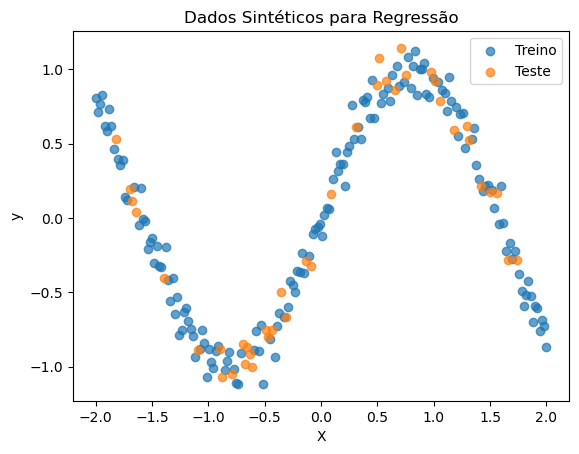

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Gerando dados sintéticos
np.random.seed(42)
X = np.linspace(-2, 2, 200).reshape(-1, 1)
y = np.sin(2*X) + 0.1 * np.random.randn(*X.shape)

# Dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizando os dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Visualizando os dados
plt.scatter(X_train, y_train, label='Treino', alpha=0.7)
plt.scatter(X_test, y_test, label='Teste', alpha=0.7)
plt.title("Dados Sintéticos para Regressão")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


In [182]:
model = MLP(
    X_train_scaled,
    y_train_scaled,
    X_test_scaled,
    y_test_scaled,
    mode="Regression",
    hidden_size=100,
    learning_rate=0.1,
    momentum=0,
    epochs=1000,
    batch_size=16,
    lambda_l2=0,
    scheduler_learning_rate=None,
    eval=True,
    seed=2,
)

In [183]:
model.train()

Epoch 1/1000 - Loss: 258.5283 | Val Loss: 231.6660
Epoch 2/1000 - Loss: 0.6710 | Val Loss: 0.6791
Epoch 3/1000 - Loss: 0.5111 | Val Loss: 0.4236
Epoch 4/1000 - Loss: 0.4258 | Val Loss: 0.4153
Epoch 5/1000 - Loss: 0.3675 | Val Loss: 0.3148
Epoch 6/1000 - Loss: 0.3143 | Val Loss: 0.2732
Epoch 7/1000 - Loss: 0.2741 | Val Loss: 0.2618
Epoch 8/1000 - Loss: 0.2390 | Val Loss: 0.2368
Epoch 9/1000 - Loss: 0.1980 | Val Loss: 0.1774
Epoch 10/1000 - Loss: 0.1718 | Val Loss: 0.1571
Epoch 11/1000 - Loss: 0.1455 | Val Loss: 0.1117
Epoch 12/1000 - Loss: 0.1245 | Val Loss: 0.1063
Epoch 13/1000 - Loss: 0.1079 | Val Loss: 0.0805
Epoch 14/1000 - Loss: 0.0942 | Val Loss: 0.0784
Epoch 15/1000 - Loss: 0.0818 | Val Loss: 0.0599
Epoch 16/1000 - Loss: 0.0760 | Val Loss: 0.0452
Epoch 17/1000 - Loss: 0.0736 | Val Loss: 0.0710
Epoch 18/1000 - Loss: 0.0603 | Val Loss: 0.0434
Epoch 19/1000 - Loss: 0.0557 | Val Loss: 0.0375
Epoch 20/1000 - Loss: 0.0516 | Val Loss: 0.0415
Epoch 21/1000 - Loss: 0.0489 | Val Loss: 0.02

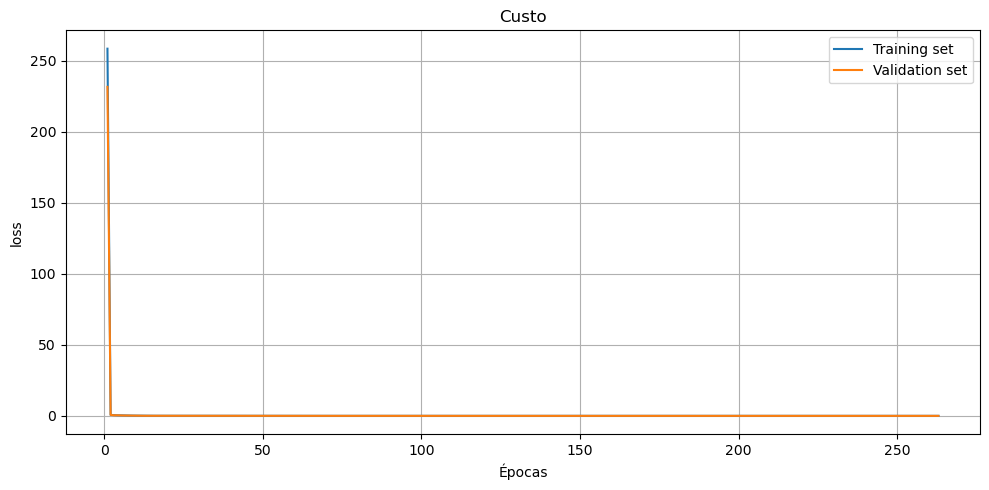

In [184]:
ep, er, er_test = zip(*model.historico_custo)
plt.figure(figsize=(10, 5))
plt.plot(ep, er, label="Training set")
plt.plot(ep, er_test, label="Validation set")
plt.xlabel("Épocas")
plt.ylabel("loss")
plt.title("Custo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [185]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)

print(f"mse: {mse:.4f}")
print(f"R²: {r2:.4f}")

mse: 0.0184
R²: 0.9848


In [186]:
X_plot = np.linspace(X_train_scaled.ravel().min(), X_train_scaled.ravel().max(), 200).reshape(-1, 1)
y_pred = model.predict(X_plot)

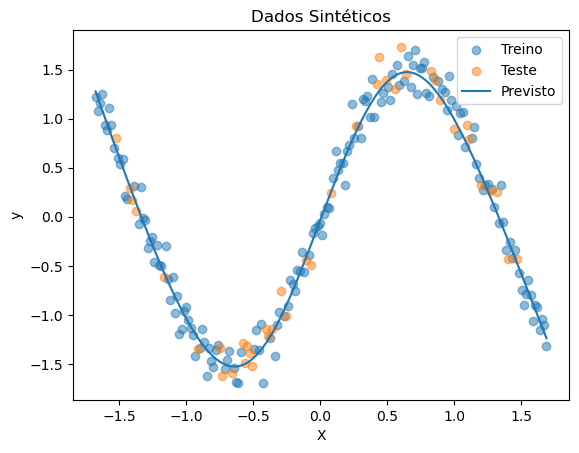

In [187]:
plt.scatter(X_train_scaled, y_train_scaled, label='Treino', alpha=0.5)
plt.scatter(X_test_scaled, y_test_scaled, label='Teste', alpha=0.5)
plt.plot(X_plot, y_pred, label='Previsto', alpha=1)
plt.title("Dados Sintéticos")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

C:\Users\altan\AppData\Local\Temp\ipykernel_31336\2064378815.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="Set1", edgecolor="k", marker="x", label="Test")


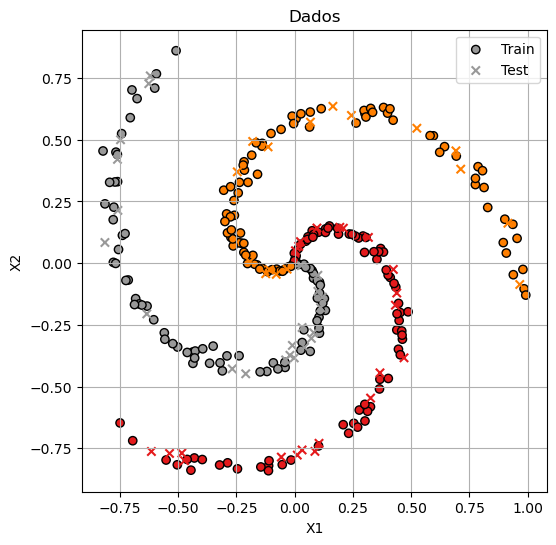

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def gerar_dados_espiral(n_classes=3, pontos_por_classe=100, ruído=0.1):
    X = []
    y = []

    rng = np.random.default_rng(42)

    for classe in range(n_classes):
        r = np.linspace(0.0, 1, pontos_por_classe)
        t = np.linspace(classe * 4, (classe + 1) * 4, pontos_por_classe) + rng.normal(0, ruído, pontos_por_classe)
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        X.append(np.c_[x1, x2])
        y.append(np.full(pontos_por_classe, classe))

    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

# Gerar dados
X, y = gerar_dados_espiral()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="Set1", edgecolor="k", label="Train")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="Set1", edgecolor="k", marker="x", label="Test")
plt.title("Dados")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()
plt.show()


In [189]:
model = MLP(
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    mode="Classification",
    hidden_size=100,
    learning_rate=0.1,
    momentum=0,
    epochs=1000,
    batch_size=16,
    lambda_l2=0,
    scheduler_learning_rate=None,
    eval=True,
    seed=2,
)

In [190]:
model.train()

Epoch 1/1000 - Loss: 0.8057 | Val Loss: 0.8107
Epoch 2/1000 - Loss: 0.6420 | Val Loss: 0.7032
Epoch 3/1000 - Loss: 0.6228 | Val Loss: 0.7208
Epoch 4/1000 - Loss: 0.5889 | Val Loss: 0.6511
Epoch 5/1000 - Loss: 0.5645 | Val Loss: 0.6185
Epoch 6/1000 - Loss: 0.5631 | Val Loss: 0.5924
Epoch 7/1000 - Loss: 0.5523 | Val Loss: 0.5923
Epoch 8/1000 - Loss: 0.4968 | Val Loss: 0.5230
Epoch 9/1000 - Loss: 0.5291 | Val Loss: 0.6353
Epoch 10/1000 - Loss: 0.4518 | Val Loss: 0.5016
Epoch 11/1000 - Loss: 0.5856 | Val Loss: 0.6686
Epoch 12/1000 - Loss: 0.4129 | Val Loss: 0.4619
Epoch 13/1000 - Loss: 0.3834 | Val Loss: 0.4458
Epoch 14/1000 - Loss: 0.3549 | Val Loss: 0.3762
Epoch 15/1000 - Loss: 0.3389 | Val Loss: 0.3583
Epoch 16/1000 - Loss: 0.3198 | Val Loss: 0.3245
Epoch 17/1000 - Loss: 0.2960 | Val Loss: 0.3035
Epoch 18/1000 - Loss: 0.3425 | Val Loss: 0.3850
Epoch 19/1000 - Loss: 0.2675 | Val Loss: 0.2824
Epoch 20/1000 - Loss: 0.2520 | Val Loss: 0.2594
Epoch 21/1000 - Loss: 0.2442 | Val Loss: 0.2535
E

Epoch 96/1000 - Loss: 0.0689 | Val Loss: 0.0457
Epoch 97/1000 - Loss: 0.0682 | Val Loss: 0.0452
Epoch 98/1000 - Loss: 0.0680 | Val Loss: 0.0447
Epoch 99/1000 - Loss: 0.0676 | Val Loss: 0.0445
Epoch 100/1000 - Loss: 0.0672 | Val Loss: 0.0440
Epoch 101/1000 - Loss: 0.0669 | Val Loss: 0.0436
Epoch 102/1000 - Loss: 0.0673 | Val Loss: 0.0439
Epoch 103/1000 - Loss: 0.0666 | Val Loss: 0.0433
Epoch 104/1000 - Loss: 0.0660 | Val Loss: 0.0427
Epoch 105/1000 - Loss: 0.0656 | Val Loss: 0.0421
Epoch 106/1000 - Loss: 0.0655 | Val Loss: 0.0419
Epoch 107/1000 - Loss: 0.0650 | Val Loss: 0.0415
Epoch 108/1000 - Loss: 0.0648 | Val Loss: 0.0412
Epoch 109/1000 - Loss: 0.0645 | Val Loss: 0.0407
Epoch 110/1000 - Loss: 0.0649 | Val Loss: 0.0412
Epoch 111/1000 - Loss: 0.0647 | Val Loss: 0.0410
Epoch 112/1000 - Loss: 0.0646 | Val Loss: 0.0408
Epoch 113/1000 - Loss: 0.0634 | Val Loss: 0.0396
Epoch 114/1000 - Loss: 0.0631 | Val Loss: 0.0393
Epoch 115/1000 - Loss: 0.0635 | Val Loss: 0.0395
Epoch 116/1000 - Loss: 0

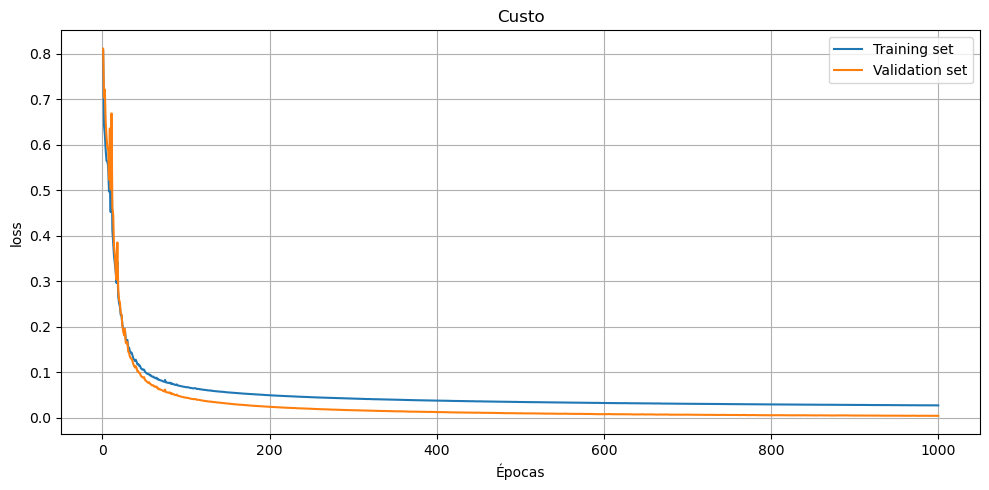

In [191]:
ep, er, er_test = zip(*model.historico_custo)
plt.figure(figsize=(10, 5))
plt.plot(ep, er, label="Training set")
plt.plot(ep, er_test, label="Validation set")
plt.xlabel("Épocas")
plt.ylabel("loss")
plt.title("Custo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [192]:
from sklearn.metrics import accuracy_score
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Acurácia Treino: {acc_train:.4f}")
print(f"Acurácia Teste: {acc_test:.4f}")

Acurácia Treino: 0.9917
Acurácia Teste: 1.0000


In [193]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(model, X, y, title="Fronteira de Decisão"):
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = model.predict(grid)

    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, cmap="Set1", alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", edgecolors="k")
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()

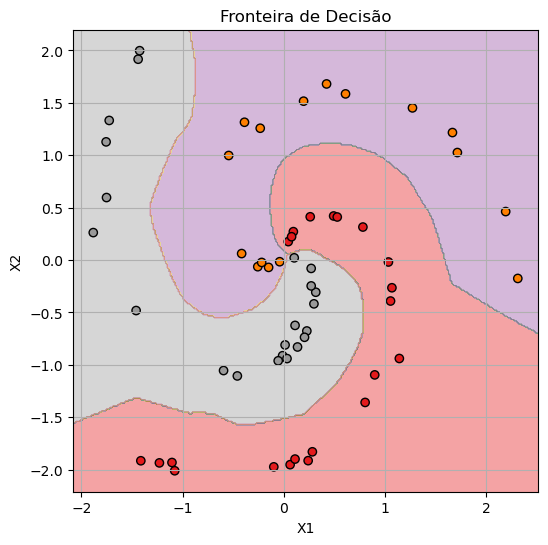

In [194]:
plot_decision_boundary(model, X_test_scaled, y_test)

In [195]:
concrete = np.loadtxt("concrete.csv", delimiter=',')

In [196]:
concrete.shape

(1030, 9)

In [197]:
X = concrete[:,0:8]

In [198]:
y = concrete[:,8].reshape(-1,1)

In [199]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=42)

In [201]:
x_scaler = StandardScaler()
X_train_standard = x_scaler.fit_transform(X_train)

In [202]:
y_scaler = StandardScaler()
y_train_standard = y_scaler.fit_transform(y_train)

In [203]:
X_validation_standard = x_scaler.transform(X_validation)

In [204]:
y_validation_standard = y_scaler.transform(y_validation)

In [234]:
model = MLP(
    X_train_standard,
    y_train_standard,
    X_validation_standard,
    y_validation_standard,
    mode="Regression",
    hidden_size=100,
    learning_rate=0.001,
    momentum=0.2,
    epochs=1000,
    batch_size=16,
    lambda_l2=0.001,
    scheduler_learning_rate=None,
    eval=True,
    seed=2,
)

In [235]:
model.train()

Epoch 1/1000 - Loss: 0.5861 | Val Loss: 0.5370
Epoch 2/1000 - Loss: 0.4194 | Val Loss: 0.3855
Epoch 3/1000 - Loss: 0.3287 | Val Loss: 0.3057
Epoch 4/1000 - Loss: 0.2808 | Val Loss: 0.2652
Epoch 5/1000 - Loss: 0.2524 | Val Loss: 0.2417
Epoch 6/1000 - Loss: 0.2352 | Val Loss: 0.2280
Epoch 7/1000 - Loss: 0.2233 | Val Loss: 0.2188
Epoch 8/1000 - Loss: 0.2150 | Val Loss: 0.2123
Epoch 9/1000 - Loss: 0.2084 | Val Loss: 0.2078
Epoch 10/1000 - Loss: 0.2033 | Val Loss: 0.2033
Epoch 11/1000 - Loss: 0.1990 | Val Loss: 0.1999
Epoch 12/1000 - Loss: 0.1954 | Val Loss: 0.1968
Epoch 13/1000 - Loss: 0.1923 | Val Loss: 0.1940
Epoch 14/1000 - Loss: 0.1895 | Val Loss: 0.1915
Epoch 15/1000 - Loss: 0.1869 | Val Loss: 0.1893
Epoch 16/1000 - Loss: 0.1847 | Val Loss: 0.1871
Epoch 17/1000 - Loss: 0.1826 | Val Loss: 0.1850
Epoch 18/1000 - Loss: 0.1807 | Val Loss: 0.1830
Epoch 19/1000 - Loss: 0.1788 | Val Loss: 0.1815
Epoch 20/1000 - Loss: 0.1772 | Val Loss: 0.1797
Epoch 21/1000 - Loss: 0.1756 | Val Loss: 0.1782
E

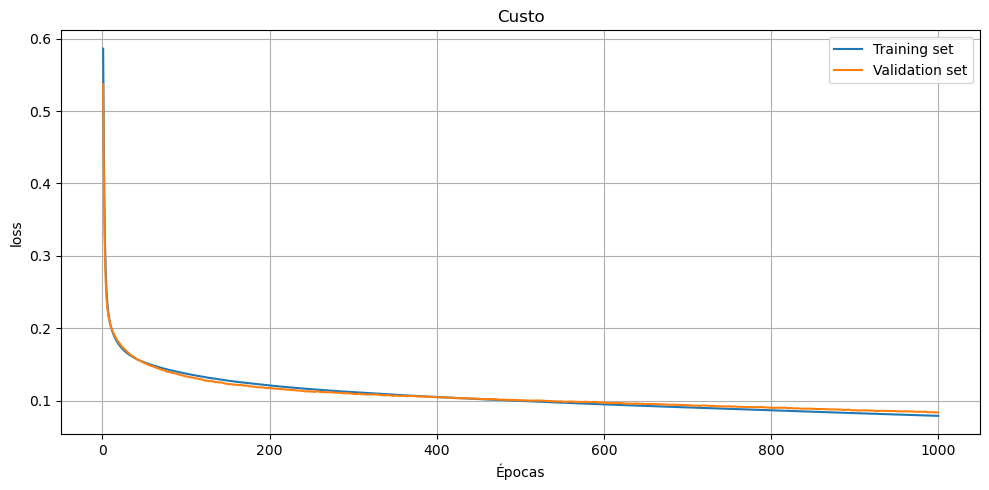

In [236]:
ep, er, er_test = zip(*model.historico_custo)
plt.figure(figsize=(10, 5))
plt.plot(ep, er, label="Training set")
plt.plot(ep, er_test, label="Validation set")
plt.xlabel("Épocas")
plt.ylabel("loss")
plt.title("Custo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
parametros_dist = {
    "hidden_size": randint(8, 500),
    "learning_rate": rv_discrete(
        name="learning_rate",
        values=([10**e for e in [-3, -2]], [1 / 2] * 2),
    ),
    "momentum": rv_discrete(name="momentum", values=([0, 0.5, 0.9], [1 / 3] * 3)),
    "batch_size": rv_discrete(name="batch_size", values=([16, 32, 64], [1 / 3] * 3)),
    "lambda_l2": rv_discrete(
        name="lambda_l2", values=([10**e for e in [-5, -3, -1, 0]], [1 / 3] * 3)
    ),
}

In [ ]:
parametros = {
    "mode": "Regression",
    "epochs": 1500,
    "eval": False,
    "seed": 2,
}

In [232]:
random_search = RandomSearchMLP(
    X_train_standard,
    y_train_standard,
    X_validation_standard,
    y_validation_standard,
    MLP,
    parameters_distributions=parametros_dist,
    parameters_other=parametros,
    repeats=50
)

In [233]:
random_search.search()

In [237]:
random_search.results

[({'hidden_size': 180,
   'learning_rate': 0.001,
   'momentum': 0.5,
   'batch_size': 32,
   'lambda_l2': 0.1},
  [(1, np.float64(0.36263763908524865), np.float64(0.3606972210667638)),
   (2, np.float64(0.2851192963402419), np.float64(0.28342127084491125)),
   (3, np.float64(0.24445393747694064), np.float64(0.24382356103355457)),
   (4, np.float64(0.22146569028383453), np.float64(0.22198899338150363)),
   (5, np.float64(0.20799228400084163), np.float64(0.20994521269229482)),
   (6, np.float64(0.1998037799767415), np.float64(0.2030436340015198)),
   (7, np.float64(0.19433992497764135), np.float64(0.1988198504858402)),
   (8, np.float64(0.1904242738185245), np.float64(0.19585005332564367)),
   (9, np.float64(0.18739900042697144), np.float64(0.19348398244191084)),
   (10, np.float64(0.1849810872580264), np.float64(0.19159290910606316)),
   (11, np.float64(0.1829569791204159), np.float64(0.18978507800996483)),
   (12, np.float64(0.18115392574695302), np.float64(0.18847698568732582)),
   (

In [238]:
best_parametros = random_search.best_params

In [239]:
best_parametros[0]

{'hidden_size': 265,
 'learning_rate': 0.001,
 'momentum': 0.9,
 'batch_size': 64,
 'lambda_l2': 0.1}

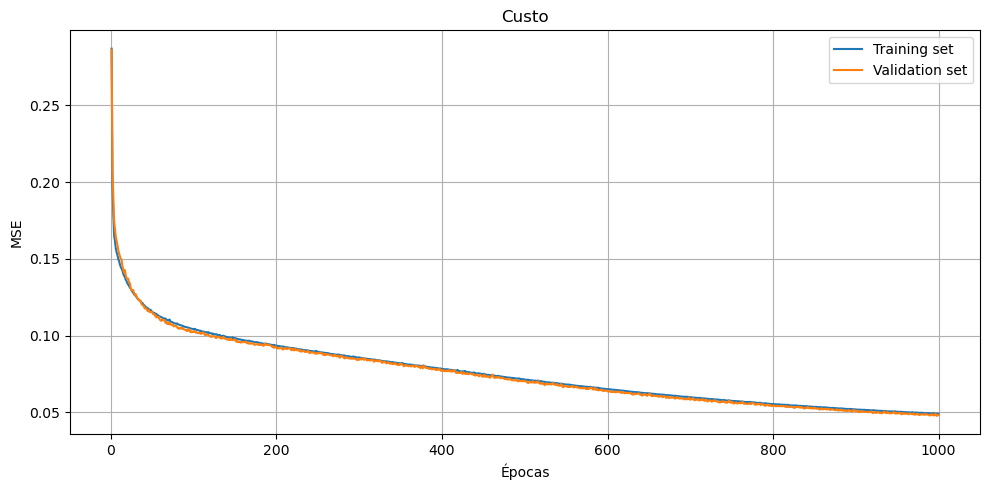

In [240]:
ep, er, er_test = zip(*best_parametros[1])
plt.figure(figsize=(10, 5))
plt.plot(ep, er, label="Training set")
plt.plot(ep, er_test, label="Validation set")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Custo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()